# 비골절, 골절 Classifier

## colab 에서 진행할 경우 (이외 건너뛰어도 무방)
- 드라이브 마운트 필요

In [15]:
# to find the directory you're in ,
!ls
#if you wanna go into a folder (say samplefolder)
%cd /content/drive/My Drive

 bones_classifier_112x112_0515_0514.ipynb
 bones_classifier_128x128_0515.ipynb
'classify_model_batchsize12_loss0.39_acc 0.87.model'
'classify_model_batchsize12_loss0.39_acc 0.87.zip'
'Colab Notebooks'
 dcgan.h5
 done
 model_images
 nlp
 resize_reverse_crop
 resize_reverse_crop_128
 resize_reverse_crop_128.zip
 resize_reverse_crop.zip
 result
 saved_model
 unet.h5
 whole
 whole_model
 whole.zip
 x-ray.zip
 yolo_test
/content/drive/My Drive


In [62]:
import os
os.getcwd()

'/content/drive/My Drive'

In [0]:
# !unzip whole.zip -d whole
# !unzip resize_reverse_crop.zip -d resize_reverse_crop
# !unzip resize_reverse_crop_128.zip -d resize_reverse_crop_128

## Load module

In [0]:
%tensorflow_version 1.x

In [0]:
from __future__ import print_function, division

import keras
from keras import optimizers, initializers, regularizers, metrics
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.optimizers import RMSprop, Adam
# from keras.models import Sequential

from os import makedirs
from os import listdir

from shutil import copyfile
from random import seed
from random import random

from matplotlib.image import imread

from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# from functools import partial

import random
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import glob
import os
import cv2
# import keras.backend.tensorflow_backend as K

In [0]:
from numpy.random import seed
# np.random.seed(seed)
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Source Data 확인
/content/drive/My Drive/resize_reverse_crop/Normal_resize_reverse_crop_128\
/content/drive/My Drive/resize_reverse_crop/fracture_resize_reverse_crop_128\

/content/drive/My Drive/resize_reverse_crop/Normal_resize_reverse_crop\
/content/drive/My Drive/resize_reverse_crop/fracture_resize_reverse_crop\

/content/drive/My Drive/whole/x-ray/Normal_resize_reverse_crop\
/content/drive/My Drive/whole/x-ray/fracture_resize_reverse_crop

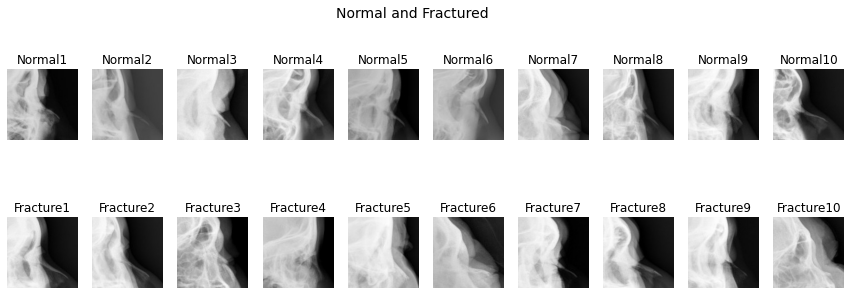

In [0]:
path_normal ='./resize_reverse_crop_128/Normal_resize_reverse_crop' #20200515
path_fracture = './resize_reverse_crop_128/fracture_resize_reverse_crop' #20200515

normal_image_path_names = []
fracture_image_path_names = []

# Get Images in folders
for file_n in glob.glob(path_normal + '/*.jpg'):
  normal_image_path_names.append(file_n)

for file_f in glob.glob(path_fracture + '/*.jpg'):
  fracture_image_path_names.append(file_f)

# Check if training data looks all right

fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10) :
  img_normal = imread(normal_image_path_names[i])
  img_fracture = imread(fracture_image_path_names[i])
  fig.suptitle('Normal and Fractured', fontsize=14)
  axs[0, i].set_axis_off()
  axs[0, i].set_title('Normal{}'.format(i+1))
  axs[0, i].imshow(img_normal, cmap='gray')
  axs[1, i].set_axis_off()
  axs[1, i].set_title('Fracture{}'.format(i+1))
  axs[1, i].imshow(img_fracture, cmap='gray')

In [0]:
print(img_normal.shape)
print(img_fracture.shape)

(128, 128, 3)
(128, 128, 3)


In [0]:
print(len(normal_image_path_names))
print(len(fracture_image_path_names))

698
1204


## ImageDataGenerator

In [0]:
## images.shape = (None, 224, 244). value = 0~225
def equalize_images(images):
    return np.array([cv2.equalizeHist(image) for image in images])
    
    
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


def generate_images_for_data_augmentation(original_path, output_path, prefix, max_gen_count):
    create_output_path(output_path)
    
    file_list = os.listdir(original_path)
    
    datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.01,
            height_shift_range=0.01,
            # shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode="nearest")
    
    for filename in file_list:
        # copy
        shutil.copyfile(original_path + "/" + filename, output_path + "/" + filename)
        
        # generates
        img = load_img(original_path + "/" + filename)  # this is a PIL image
        
        img_data = img_to_array(img) # this is a Numpy array
        img_data = img_data.reshape((1,) + img_data.shape)  # this is a Numpy array 

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        generated_count = 0
        
        for batch in datagen.flow(img_data, batch_size = 1,
                                  save_to_dir=output_path, save_prefix=prefix, save_format="jpg"):
            generated_count += 1

            if generated_count > max_gen_count:
                break  # otherwise the generator would loop indefinitely

In [0]:
src_dir_noraml = './resize_reverse_crop_128/Normal_resize_reverse_crop'
src_dir_fracture = './resize_reverse_crop_128/fracture_resize_reverse_crop'

copy_dir_normal = './image_generated/Normal_resize_reverse_crop'
copy_dir_fracture = './image_generated/fracture_resize_reverse_crop'

makedirs(copy_dir_normal, exist_ok=True)
makedirs(copy_dir_fracture, exist_ok=True)

In [0]:
# generate_images_for_data_augmentation(original_path, output_path, prefix, max_gen_count)
generate_images_for_data_augmentation(src_dir_noraml, copy_dir_normal, '', 21)

In [0]:
# generate_images_for_data_augmentation(original_path, output_path, prefix, max_gen_count)
generate_images_for_data_augmentation(src_dir_fracture, copy_dir_fracture, '', 21)

## Train set, Test set 디렉토리 분류
###  이미 디렉토리 안에 파일이 생성되어 있는 경우 지나가도 됨

 classifier\
   ├── test\
   │   ├── fracture\
   │   └── normal\
   └── train\
  ----      ├── fracture\
  ----      └── normal



Ref:\
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [0]:
# organize dataset into a useful structure

# from os import makedirs
# from os import listdir
# from shutil import copyfile
# from random import seed
# from random import random

## Step1
# create directories
dataset_home = './resize_reverse_crop_128/classifier/' #20200515
subdirs = ['images/train/', 'images/test/']
labeldirs = ['fracture/', 'normal/']

for subdir in subdirs:
  for labeldir in labeldirs:
    newdir = dataset_home + subdir + labeldir
    makedirs(newdir, exist_ok=True)
print('== Step1 is done ==')


## Step2
# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.2
# val_ratio = 0.3

# copy training dataset images into subdirectories

path_normal = './resize_reverse_crop_128/Normal_resize_reverse_crop' #20200515
path_fracture = './resize_reverse_crop_128/fracture_resize_reverse_crop' #20200515


src_path = [path_fracture, path_normal]
for path in src_path:
  for file in listdir(path):
    src = path + '/' + file # './resize_reverse_crop_128/Normal_resize_reverse_crop/*.jpg'
    lab_dir = path.split('/')[-1].split('_')[0].lower() # fracture, normal
    if random() > val_ratio:
      subdir = 'images/train/'
      dst = dataset_home + subdir + lab_dir + '/'  + file # '.classifier/images/클래스(fracture, normal)'
      copyfile(src, dst)
    else:
      subdir = 'images/test/'
      dst = dataset_home + subdir + lab_dir + '/'  + file # '.classifier/images/클래스(fracture, normal)'
      copyfile(src, dst)
print('== Step2 is done ==')

## X_train, X_test, Y_train, Y_test 마련

Ref:\
https://github.com/lsjsj92/keras_basic/blob/master/6.%20predict_binary_img_with_CNN.ipynb

In [6]:
# from PIL import Image
# import os, glob, sys, numpy as np
# from os import makedirs
# from sklearn.model_selection import train_test_split
# from keras.utils import np_utils

img_dir = './resize_reverse_crop_128/classifier/images/train' #20200515
# categories = list(class_names)
categories = ['normal', 'fracture']
np_classes = len(categories)

img_w = 128 #20200515
img_h = 128 #20200515
# channel = 3
channel = 1 #20200515

pixel = img_w * img_h * channel

X = []
y = []

for idx, category in enumerate(categories):
  img_dir_detail = img_dir + '/' + category
  files = glob.glob(img_dir_detail + '/*.jpg')

  for i, f in enumerate(files):
    try:
      img = Image.open(f).convert('L') #20200515
      # img = img.convert('RGB')
      img = img.resize((img_w, img_h))
      data = np.asarray(img)
      # print(data.shape)
      X.append(data)
      y.append(idx)
      if i % 300 == 0:
        print(category, ":", f)
    except:
      print(category, str(i), 'Error')

X = np.array(X)
Y = np.array(y)

##20200518
shuffled_train_index = np.random.permutation(X.shape[0])
X = X[shuffled_train_index,:,:]
Y = Y[shuffled_train_index]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)

normal : ./resize_reverse_crop_128/classifier/images/train/normal/1402r.jpg
normal : ./resize_reverse_crop_128/classifier/images/train/normal/1715l.jpg
fracture : ./resize_reverse_crop_128/classifier/images/train/fracture/204r.jpg
fracture : ./resize_reverse_crop_128/classifier/images/train/fracture/429r.jpg
fracture : ./resize_reverse_crop_128/classifier/images/train/fracture/1169l.jpg
fracture : ./resize_reverse_crop_128/classifier/images/train/fracture/187l.jpg


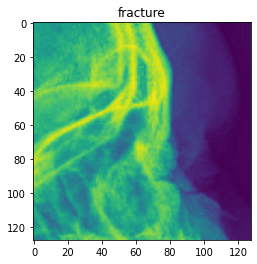

In [8]:
# Check X_train data by plotting

# import random
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

ix = random.randint(1, X_train.shape[0])
plt.imshow(X_train[ix])
if Y_train[ix] == 0:
  plt.title('normal')
elif Y_train[ix] == 1:
  plt.title('fracture')
plt.show()

### 나눈 Train and Test set을 numpy data로 저장

In [0]:
numpy_dir = './resize_reverse_crop_128/classifier/numpy_data' #20200515
numpy_data = './resize_reverse_crop_128/classifier/numpy_data/binary_image_data.npy' #20200515

makedirs(numpy_dir, exist_ok=True)
np.save(numpy_data, xy)

## Classifier model

In [0]:
# from keras.models import Sequential
# from keras.optimizers import RMSprop
# from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from matplotlib.image import imread
# import matplotlib.pyplot as plt
# import keras.backend.tensorflow_backend as K
# import random

### loss 0.39 acc 0.87 (sigmoid)

In [0]:
# loss 0.39 acc 0.87

def classifier_model(img_size, channels):
    inputs = Input(shape=(img_size, img_size, channels))
    depth = 8

    conv0 = Conv2D(depth*1, (3,3), padding='same')(inputs)
    conv0 = LeakyReLU(0.2)(conv0)
    bat0 = BatchNormalization()(conv0)
    # drop0 = Dropout(0.1)(bat0)
    drop0 = Dropout(0.1)(bat0)
    # conv0 = Conv2D(depth, (3,3), padding='same')(bat0)
    # conv0 = LeakyReLU(0.2)(conv0)
    # bat0 = BatchNormalization()(conv0)
    pool0 = MaxPooling2D(pool_size=(2,2))(drop0)
    drop0 = Dropout(0.1)(pool0)

    conv1 = Conv2D(depth*2, (3,3), padding='same')(drop0)
    conv1 = LeakyReLU(0.2)(conv1)
    bat1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.1)(bat1)
    # conv1 = Conv2D(depth*2, (3,3), padding='same')(bat1)
    # conv1 = LeakyReLU(0.2)(conv1)
    # bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(drop1)
    drop1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(depth*4, (3,3), padding='same')(drop1)
    conv2 = LeakyReLU(0.2)(conv2)
    bat2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(bat2)
    # conv2 = Conv2D(depth*4, (5,5), padding='same')(bat2)
    # conv2 = LeakyReLU(0.2)(conv2)
    # bat2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(drop2)
    drop2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(depth*8, (3,3), padding='same')(drop2)
    conv3 = LeakyReLU(0.2)(conv3)
    bat3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(bat3)
    # conv3 = Conv2D(depth*8, (3,3), padding='same')(bat3)
    # conv3 = LeakyReLU(0.2)(conv3)
    # bat3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(drop3)
    drop3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(depth*16, (3,3), padding='same')(drop3)
    conv4 = LeakyReLU(0.2)(conv4)
    bat4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.1)(bat4)
    # conv4 = Conv2D(depth*16, (3,3), padding='same')(bat4)
    # conv4 = LeakyReLU(0.2)(conv4)
    # bat4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)
    drop4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(depth*32, (3,3), padding='same')(drop4)
    conv5 = LeakyReLU(0.2)(conv5)
    bat5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.1)(bat5)
    # conv5 = Conv2D(depth*32, (3,3))(drop5)
    # conv5 = LeakyReLU(0.2)(conv5)
    # bat5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2,2))(drop5)
    drop5 = Dropout(0.1)(pool5)

    conv6 = Conv2D(depth*64, (3,3), padding='same')(drop5)
    conv6 = LeakyReLU(0.2)(conv6)
    bat6 = BatchNormalization()(conv6)
    drop6 = Dropout(0.25)(bat6)
    # drop6 = Dropout(0.5)(bat6)
    # conv6 = Conv2D(depth*64, (3,3))(drop5)
    # conv6 = LeakyReLU(0.2)(conv6)
    # bat6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2,2))(drop6)
    drop6 = Dropout(0.25)(pool6)
    # drop6 = Dropout(0.5)(pool6)

    conv7 = Conv2D(depth*128, (3,3), padding='same')(drop6)
    conv7 = LeakyReLU(0.2)(conv7)
    bat7 = BatchNormalization()(conv7)
    drop7 = Dropout(0.25)(bat7) 
    # drop7 = Dropout(0.5)(bat7)

    fc = Flatten()(drop7)
    fc = Dense(depth*128, kernel_regularizer=regularizers.l2(1e-4))(fc)
    fc = LeakyReLU(0.2)(fc)
    fc = Dropout(0.5)(fc)
    fc = Dense(1)(fc)
    outputs = Activation('sigmoid')(fc)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

### unet_상위모델(softmax 버전 - jupyter)

In [0]:
def classifier_model():

    inputs = Input((default_crop_rect_height, default_crop_rect_width, 1))

    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(inputs)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(0.9)(pool1) ##20200518
    pool1 = Dropout(0.25)(pool1)

    # conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool1)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(0.25)(pool2)
    pool2 = Dropout(0.5)(pool2) ##20200518

    ##
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool2)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)
    # pool3 = Dropout(0.75)(pool3) ##20200518

    ##
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    # conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(0.25)(pool4)
    pool4 = Dropout(0.5)(pool4) ##20200518

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool3)

    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(0.25)(pool5)
    # pool5 = Dropout(0.5)(pool5) ##20200518
    d_conv_output = pool5


    dense1 = Flatten()(d_conv_output)
    dense2 = Dense(512, activation="elu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.5)(dense2)
    d_outputs = Dense(2, activation="softmax")(dense2)
    # d_outputs = Dense(1, activation="sigmoid")(dense2)

    d_model = Model([inputs], [d_outputs])
    d_model.summary()

    return  d_model

### unet_상위모델 (sigmoid 버전)

In [0]:
def classifier_model():

    inputs = Input((default_crop_rect_height, default_crop_rect_width, 1))

    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(inputs)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.9)(pool1) ##20200518
    # pool1 = Dropout(0.25)(pool1)

    # conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool1)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(0.25)(pool2)
    pool2 = Dropout(0.75)(pool2) ##20200518

    ##
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool2)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # pool3 = Dropout(0.25)(pool3)
    pool3 = Dropout(0.75)(pool3) ##20200518

    ##
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(0.25)(pool4)
    pool4 = Dropout(0.5)(pool4) ##20200518

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool3)

    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    # pool5 = Dropout(0.25)(pool5)
    pool5 = Dropout(0.5)(pool5) ##20200518
    d_conv_output = pool5


    dense1 = Flatten()(d_conv_output)
    dense2 = Dense(512, activation="elu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.5)(dense2)
    # d_outputs = Dense(2, activation="softmax")(dense2)
    d_outputs = Dense(1, activation="sigmoid")(dense2)

    d_model = Model([inputs], [d_outputs])
    d_model.summary()

    return  d_model

### take1 (shallow layers) (softmax, elu)

In [0]:
def classifier_model():

    inputs = Input((default_crop_rect_height, default_crop_rect_width, 1))


    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(0.9)(pool1) ##20200518
    pool1 = Dropout(0.25)(pool1)


    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)
    # pool2 = Dropout(0.5)(pool2) ##20200518

    # ##
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)
    # pool3 = Dropout(0.75)(pool3) ##20200518

    # ##
    # conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool3)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    # conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)
    # pool4 = Dropout(0.5)(pool4) ##20200518

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool2)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)

    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(0.25)(pool5)
    # pool5 = Dropout(0.5)(pool5) ##20200518
    d_conv_output = pool5


    dense1 = Flatten()(d_conv_output)
    # dense2 = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = Dense(512, activation="elu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = BatchNormalization()(dense2)
    # dense2 = Dropout(0.5)(dense2)
    dense2 = Dropout(0.5)(dense2) ##20200519
    d_outputs = Dense(2, activation="softmax")(dense2)
    # d_outputs = Dense(1, activation="sigmoid")(dense2)

    d_model = Model([inputs], [d_outputs])
    d_model.summary()

    return  d_model

### take2 (LeakyReLU) (softmax)

In [0]:
def classifier_model():

    inputs = Input((default_crop_rect_height, default_crop_rect_width, 1))

    # conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(inputs)
    # conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1) ##20200518
    conv1 = BatchNormalization()(conv1)
    # conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(0.2)(conv1) ##20200518
    conv1 = BatchNormalization()(conv1)
    # conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(0.2)(conv1) ##20200518
    conv1 = BatchNormalization()(conv1)
    # conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(0.2)(conv1) ##20200518
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1) ##20200518
    # pool1 = Dropout(0.25)(pool1)

    # conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool1)
    # conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2) ##20200518
    conv2 = BatchNormalization()(conv2)
    # conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(0.2)(conv2) ##20200518
    conv2 = BatchNormalization()(conv2)
    # conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(0.2)(conv2) ##20200518
    conv2 = BatchNormalization()(conv2)
    # conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(0.2)(conv2) ##20200518
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(0.25)(pool2)
    pool2 = Dropout(0.25)(pool2) ##20200518

    ##
    # conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool2)
    # conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = LeakyReLU(0.2)(conv3) ##20200518
    conv3 = BatchNormalization()(conv3)
    # conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(0.2)(conv3) ##20200518
    conv3 = BatchNormalization()(conv3)

    ##
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(0.2)(conv3) ##20200518
    conv3 = BatchNormalization()(conv3)

    ##
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(0.2)(conv3) ##20200518
    conv3 = BatchNormalization()(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # pool3 = Dropout(0.25)(pool3)
    pool3 = Dropout(0.5)(pool3) ##20200518

    ##
    # conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = LeakyReLU(0.2)(conv4) ##20200518
    conv4 = BatchNormalization()(conv4)
    # conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(0.2)(conv4) ##20200518
    conv4 = BatchNormalization()(conv4)

    ##
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(0.2)(conv4) ##20200518
    conv4 = BatchNormalization()(conv4)

    ##
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(0.2)(conv4) ##20200518
    conv4 = BatchNormalization()(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(0.25)(pool4)
    pool4 = Dropout(0.25)(pool4) ##20200518

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-3))(pool3)

    # conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool2)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = LeakyReLU(0.2)(conv5) ##20200518
    conv5 = BatchNormalization()(conv5)
    # conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(0.2)(conv5) ##20200518
    conv5 = BatchNormalization()(conv5)

    ##
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(0.2)(conv5) ##20200518
    conv5 = BatchNormalization()(conv5)

    ##
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(0.2)(conv5) ##20200518
    conv5 = BatchNormalization()(conv5)
    
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    # pool5 = Dropout(0.25)(pool5)
    pool5 = Dropout(0.5)(pool5) ##20200518
    d_conv_output = pool5


    dense1 = Flatten()(d_conv_output)
    # dense2 = Dense(512, activation="elu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = Dense(512, kernel_regularizer=regularizers.l2(1e-3))(dense1)
    dense2 = LeakyReLU(0.2)(dense2) ##20200518
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.5)(dense2)
    d_outputs = Dense(2, activation="softmax")(dense2)
    # d_outputs = Dense(1, activation="sigmoid")(dense2)

    d_model = Model([inputs], [d_outputs])
    d_model.summary()

    return  d_model

## 저장해둔 train, test set 불러오기

In [0]:
numpy_dir = './resize_reverse_crop_128/classifier/numpy_data' #20200515
numpy_data = './resize_reverse_crop_128/classifier/numpy_data/binary_image_data.npy' #20200515

In [22]:
X_train, X_test, y_train, y_test = np.load(numpy_data, allow_pickle=True)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis =-1)

print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(1383, 128, 128, 1)
1383
[501 882]
[ 53 101]


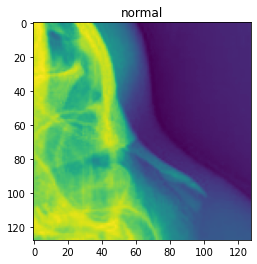

In [23]:
# Check X_train data by plotting befor training

ix = random.randint(1, X_train.shape[0])
plt.imshow(X_train[ix].reshape((128, 128)))
if y_train[ix] == 0:
  plt.title('normal')
elif y_train[ix] == 1:
  plt.title('fracture')
plt.show()

In [0]:
# _, _, image_size, channels = X_train.shape
# _, _, image_size, channels = X_train.shape
_, default_crop_rect_height, default_crop_rect_width, _ = X_train.shape ##20200516
X_train = X_train.astype('float32') / 127.5 - 1
X_test = X_test.astype('float32') / 127.5 - 1
# print(image_size, channels) ##20200516

## 모델 컴파일

In [57]:
# classifier = classifier_model(image_size, channels)
classifier = classifier_model() ## 20200516
# classifier.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
classifier.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_129 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_130 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_131 (Bat (None, 128, 128, 32)      128 

### Set ModelCheckpoint and EalryStopping

In [0]:
# model_dir = './whole/x-ray/classifier/model'
# model_dir = './resize_reverse_crop_128/classifier/model'
model_dir = './resize_reverse_crop_128/classifier/remodeled' #20200516
makedirs(model_dir, exist_ok=True)

model_path = model_dir + "/classifier_batchsize8_loss{val_loss:.2f}_acc{val_accuracy: .2f}_elu.h5" #20200518 (default softmax, dropout 0.25)
# model_path = model_dir + "/fracture_normal_classify_model_batch_size20.model"
    
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
# checkpoint = ModelCheckpoint(filepath=model_path, monitor='accuracy', verbose=1, save_best_only=True)
# checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

## 모델 훈련

In [59]:
# # history = classifier.fit(X_train, y_train, batch_size=16, epochs=300, validation_split=0.3, callbacks=[checkpoint]) ##########
# history = classifier.fit(X_train, y_train, batch_size=16, epochs=2000, validation_split=0.15, callbacks=[checkpoint, early_stopping])
# # history = classifier.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

from livelossplot import PlotLossesKeras
history = classifier.fit(X_train, y_train, batch_size = 16, epochs=200, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras(), checkpoint], verbose=0)

Train on 1175 samples, validate on 208 samples
Epoch 1/2000
1175/1175 [==============================] - 10s 9ms/step - loss: 2.3004 - accuracy: 0.5668 - val_loss: 3.6388 - val_accuracy: 0.6010

Epoch 00001: val_loss improved from inf to 3.63876, saving model to ./resize_reverse_crop_128/classifier/remodeled/classifier_batchsize8_loss3.64_acc 0.60_elu.h5
Epoch 2/2000
1175/1175 [==============================] - 6s 5ms/step - loss: 1.7354 - accuracy: 0.6017 - val_loss: 1.9596 - val_accuracy: 0.5577

Epoch 00002: val_loss improved from 3.63876 to 1.95958, saving model to ./resize_reverse_crop_128/classifier/remodeled/classifier_batchsize8_loss1.96_acc 0.56_elu.h5
Epoch 3/2000
1175/1175 [==============================] - 6s 5ms/step - loss: 1.6709 - accuracy: 0.5855 - val_loss: 1.7903 - val_accuracy: 0.5625

Epoch 00003: val_loss improved from 1.95958 to 1.79027, saving model to ./resize_reverse_crop_128/classifier/remodeled/classifier_batchsize8_loss1.79_acc 0.56_elu.h5
Epoch 4/2000
1175

### Accuracy

In [60]:
print("정확도 : %.2f " %(classifier.evaluate(X_test, y_test)[1]))

154/154 [==============================] - 0s 969us/step
정확도 : 0.81 


### 그래프: loss, accuracy

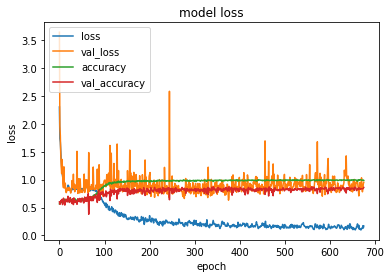

In [61]:
# import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

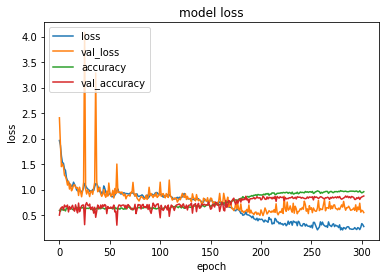

In [0]:
# import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

## Classifier model 검증하기 (Test directory)

(365, 128, 128)


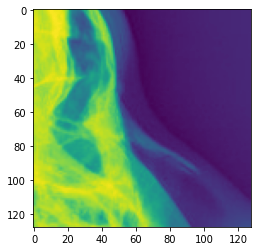

In [0]:
# from PIL import Image
# import os, glob, random, numpy as np
# from keras.models import load_model
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

seed = 5
# tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './resize_reverse_crop_128/classifier/images/test' #20200515


# img_w = 224
img_w = 128 #20200515
# img_h = 224
img_h = 128 #20200515
# channel = 3
channel = 1

pixels = img_h * img_w * channel

X = []
filenames = []
files = glob.glob(caltech_dir + "/*/*.*")
for i, f in enumerate(files):
    img = Image.open(f).convert('L') #20200515
    # img = img.convert('RGB')
    img = img.resize((img_w, img_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)

X = np.array(X)

##20200518
shuffled_train_index = np.random.permutation(X.shape[0])
X = X[shuffled_train_index,:,:]

print(X.shape)

ix = random.randint(1, X.shape[0])
plt.imshow(X[ix])
plt.show()

In [0]:
X = np.expand_dims(X, axis=-1)
X = X.astype(float) / 127.5 - 1

### prediction and result

In [0]:
# model = load_model('./whole/x-ray/classifier/model/fracture_normal_classify.model')
# model = load_model('./whole/x-ray/classifier/model/fracture_normal_classify_model.model')

model = load_model('./resize_reverse_crop_128/classifier/remodeled/remodeled_classifier_batchsize8_loss0.49_acc 0.88.h5') #20200518
prediction = model.predict(X)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

cnt = 0
for i in prediction:
    if i[1] >= 0.5: ##20200518
      print("해당 " + filenames[cnt].split("/")[-2] + ' ' + filenames[cnt].split("/")[-1] + "  이미지는 1: 골절 로 추정됩니다.")
    else :
      print("해당 " + filenames[cnt].split("/")[-2] + ' ' + filenames[cnt].split("/")[-1] + "  이미지는 0: 비골절 로 추정됩니다.")
    cnt += 1

해당 fracture 1030r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1036l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1038l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1043l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1043r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1047r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1054l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1056l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1057r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1064r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1066r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1071l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1071r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1074l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1082l.jpg  이미지는 0: 비골절 로 추정됩니다.
해당 fracture 1086r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1088l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1093r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1094r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1099l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1099r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 109l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 10r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1

In [0]:
print(prediction)

[[0.007 0.993]
 [0.492 0.508]
 [0.002 0.998]
 [0.007 0.993]
 [0.040 0.960]
 [0.178 0.822]
 [0.019 0.981]
 [0.031 0.969]
 [0.010 0.990]
 [0.296 0.704]
 [0.127 0.873]
 [0.007 0.993]
 [0.007 0.993]
 [0.004 0.996]
 [0.604 0.396]
 [0.242 0.758]
 [0.046 0.954]
 [0.010 0.990]
 [0.079 0.921]
 [0.078 0.922]
 [0.261 0.739]
 [0.056 0.944]
 [0.006 0.994]
 [0.011 0.989]
 [0.473 0.527]
 [0.870 0.130]
 [0.010 0.990]
 [0.085 0.915]
 [0.581 0.419]
 [0.691 0.309]
 [0.015 0.985]
 [0.058 0.942]
 [0.002 0.998]
 [0.029 0.971]
 [0.013 0.987]
 [0.001 0.999]
 [0.043 0.957]
 [0.027 0.973]
 [0.033 0.967]
 [0.047 0.953]
 [0.006 0.994]
 [0.076 0.924]
 [0.005 0.995]
 [0.077 0.923]
 [0.008 0.992]
 [0.030 0.970]
 [0.722 0.278]
 [0.023 0.977]
 [0.092 0.908]
 [0.031 0.969]
 [0.009 0.991]
 [0.087 0.913]
 [0.013 0.987]
 [0.009 0.991]
 [0.080 0.920]
 [0.036 0.964]
 [0.001 0.999]
 [0.100 0.900]
 [0.069 0.931]
 [0.032 0.968]
 [0.063 0.937]
 [0.315 0.685]
 [0.025 0.975]
 [0.014 0.986]
 [0.007 0.993]
 [0.041 0.959]
 [0.157 0.

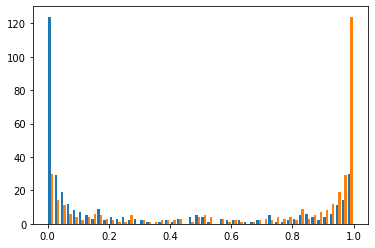

In [0]:
# import matplotlib.pyplot as plt
plt.hist(prediction, bins=50)
plt.show()

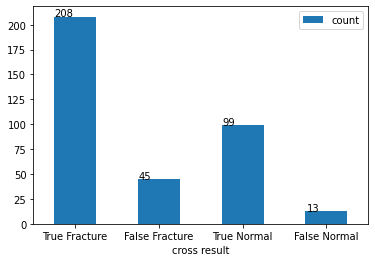

In [0]:
# import pandas as pd
# import matplotlib.pyplot as plt

cnt = 0

TF = []
FF = []
TN = []
FN = []
for i in prediction:
  if i[1] >= 0.5: ##20200518
    if filenames[cnt].split("/")[-2] == 'fracture':
      TF.append(i)
    elif filenames[cnt].split("/")[-2] == 'normal':
      FF.append(i)
  else:
    if filenames[cnt].split("/")[-2] == 'normal':
      TN.append(i)
    elif filenames[cnt].split("/")[-2] == 'fracture':
      FN.append(i)
  cnt += 1



df = pd.DataFrame({'cross result':['True Fracture', 'False Fracture', 'True Normal', 'False Normal'], 'count':[len(TF), len(FF), len(TN), len(FN)]})
ax = df.plot.bar(x='cross result', y='count', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()